# Coursework Assignment.

# Big Data For Decision Making BNM832

### Student Number: 210190421




# Business Objective

The project aims to predict the severity of the casualty in order to be well equipped and provide the required emmergency care as soon as possible. 

In this case, predicting cases of Fatal and Severe correctly is of highest importance as the hospital would need to be prepared with the right setup required for such cases where time is of atmost importance.

we want our model to predict the Fatal and Severe cases with high accurary, that is we wish to increase the True Positive rate. Thus we try to achieve this using following machine learning algorithms.

In [2]:
#Importing all necessary dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support
from statistics import mode
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

#Using pickle to save and retrieve the model
import pickle

In [1]:
import os 
dir_path = os.path.dirname(os.path.realpath(__file__))

NameError: name '__file__' is not defined

In [3]:
#ignoring warnings
warnings.simplefilter("ignore")

trainset = pd.read_csv('Downloads/trainset.csv')

trainset.head()

,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty_category,casualty_severity,casualty_home_area_type,longitude,latitude,police_force,accident_severity,number_of_casualties,date,day_of_week,time,did_police_officer_attend_scene_of_accident,time_category,casualty_vehicle_category,month
0,Passenger,Female,54,Adult,Slight,Urban Area,-2.284415,53.531991,Other Police Force,Slight Accident,1,18/05/2020,Monday,11:07,Yes,Late Morning,Two Wheeler,5
1,Driver or Rider,Female,18,Teen,Slight,Urban Area,-1.598269,54.892889,Other Police Force,Slight Accident,2,11/06/2020,Thursday,16:53,No,Late Afternoon,Four Wheeler,11
2,Driver or Rider,Male,42,Adult,Slight,Rural,-5.228256,50.211542,Other Police Force,Slight Accident,2,23/09/2020,Wednesday,07:40,Yes,Early Morning,Four Wheeler,9
3,Driver or Rider,Male,35,Young Adult,Slight,Urban Area,-3.616745,55.081706,Scotland Police,Serious Accident,2,31/08/2020,Monday,16:18,Yes,Late Afternoon,Multi axle,8
4,Driver or Rider,Male,44,Adult,Serious,Urban Area,-1.610599,52.245520,Other Police Force,Serious Accident,1,30/09/2020,Wednesday,13:00,Yes,Early Afternoon,Multi axle,9


Loading the testset

In [4]:
testset = pd.read_csv('Downloads/testset.csv')

testset.head()

,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty_category,casualty_severity,casualty_home_area_type,longitude,latitude,police_force,accident_severity,number_of_casualties,date,day_of_week,time,did_police_officer_attend_scene_of_accident,time_category,casualty_vehicle_category,month
0,Driver or Rider,Female,50,Adult,Serious,Urban Area,-0.330940,53.744729,Other Police Force,Serious Accident,1,14/09/2020,Monday,06:40,Yes,Early Morning,Two Wheeler,9
1,Driver or Rider,Male,26,Young Adult,Serious,Rural,-0.812116,51.092429,Other Police Force,Serious Accident,1,23/08/2020,Sunday,14:36,No,Early Afternoon,Two Wheeler,8
2,Driver or Rider,Male,36,Adult,Slight,Urban Area,-0.571828,53.206321,Other Police Force,Slight Accident,3,28/04/2020,Tuesday,17:00,Yes,Late Afternoon,Four Wheeler,4
3,Driver or Rider,Female,60,Adult,Slight,Urban Area,0.588357,51.337145,Other Police Force,Slight Accident,3,27/09/2020,Sunday,14:33,Yes,Early Afternoon,Four Wheeler,9
4,Driver or Rider,Male,26,Young Adult,Serious,Rural,-3.002490,53.367162,Other Police Force,Serious Accident,1,25/03/2020,Wednesday,19:02,Yes,Early Evening,Two Wheeler,3


In [5]:
trainset.columns

Index(['casualty_class', 'sex_of_casualty', 'age_of_casualty',
       'age_band_of_casualty_category', 'casualty_severity',
       'casualty_home_area_type', 'longitude', 'latitude', 'police_force',
       'accident_severity', 'number_of_casualties', 'date', 'day_of_week',
       'time', 'did_police_officer_attend_scene_of_accident', 'time_category',
       'casualty_vehicle_category', 'month'],
      dtype='object')

## Utilities

In [6]:
#Function to configure all aspects of the graph 
def configureGraph(axis, plot, xLabelTitle, xLabelSize, yLabelTitle,
                   yLabelSize, showGrid, graphTitle, titleSize = 20):
    try:
        configureGraphForNonFacets(axis, xLabelTitle, xLabelSize, yLabelTitle,
                                   yLabelSize, graphTitle, titleSize)
    except AttributeError:
        configureGraphForFacets(axis, plot, xLabelTitle, xLabelSize,
                                yLabelTitle, yLabelSize, graphTitle, titleSize)
    if showGrid:
        plot.grid()

#Configures grapgh properties for type non facets
def configureGraphForNonFacets(axis, xLabelTitle, xLabelSize, yLabelTitle,
                               yLabelSize, graphTitle, titleSize = 20):
    axis.set_title(graphTitle, size = titleSize, weight='bold')
    axis.set_xlabel(xLabelTitle, size=xLabelSize)
    axis.set_ylabel(yLabelTitle, size=yLabelSize)

#Configures graph properties for type facets
def configureGraphForFacets(axis, plot, xLabelTitle, xLabelSize, yLabelTitle,
                            yLabelSize, graphTitle, titleSize = 20):
    axis.set_axis_labels(x_var=xLabelTitle,
                         y_var=yLabelTitle,
                         fontsize=xLabelSize)
    if graphTitle != "":
        plot.title(graphTitle,fontsize = titleSize)
        
#Encodes the given dataframe for the features provided
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first = True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

#Saves the model with path and name given in 'modelName'
def saveModel(modelName, model):
    with open(modelName, 'wb') as f:
        pickle.dump(model, f)

#Retrieves the saved model from the disk, returns None if not found.        
def getModel(modelName):
    try:
        with open(modelName, 'rb') as f:
            model = pickle.load(f)
            return model
    except FileNotFoundError:
        return None
    
def displayScores(gridSearchCVResults):
    results = pd.DataFrame(gridSearchCVResults)[[
    'params', 'mean_train_score', 'mean_test_score'
    ]]
    results["diff, %"] = 100 * (
    results["mean_train_score"] -
    results["mean_test_score"]) / results["mean_train_score"]

    pd.set_option('display.max_colwidth', 100)
    results.sort_values('mean_test_score', ascending=False)
    display(results)

We proceed by first dropping columns which are not required for 

modelling and were used for Exploratory Data Analysis.

In [6]:

dataFrameTrain = trainset.drop([
    'police_force', 'date', 'time', 'did_police_officer_attend_scene_of_accident'
],
                               axis=1)
#Get the data types information to verify the drop
dataFrameTrain.info()

#Checking for any null values if missed previously
print(dataFrameTrain.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67402 entries, 0 to 67401
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   casualty_class                 67402 non-null  object 
 1   sex_of_casualty                67402 non-null  object 
 2   age_of_casualty                67402 non-null  int64  
 3   age_band_of_casualty_category  67325 non-null  object 
 4   casualty_severity              67402 non-null  object 
 5   casualty_home_area_type        67402 non-null  object 
 6   longitude                      67402 non-null  float64
 7   latitude                       67402 non-null  float64
 8   accident_severity              67402 non-null  object 
 9   number_of_casualties           67402 non-null  int64  
 10  day_of_week                    67402 non-null  object 
 11  time_category                  67402 non-null  object 
 12  casualty_vehicle_category      67402 non-null 

In [7]:
#Drop on testset as well
dataFrameTest = testset.drop([
    'police_force', 'date', 'time', 'did_police_officer_attend_scene_of_accident'
],
                             axis=1)
dataFrameTest.info()

print(dataFrameTest.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17243 entries, 0 to 17242
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   casualty_class                 17243 non-null  object 
 1   sex_of_casualty                17243 non-null  object 
 2   age_of_casualty                17243 non-null  int64  
 3   age_band_of_casualty_category  17235 non-null  object 
 4   casualty_severity              17243 non-null  object 
 5   casualty_home_area_type        17243 non-null  object 
 6   longitude                      17243 non-null  float64
 7   latitude                       17243 non-null  float64
 8   accident_severity              17243 non-null  object 
 9   number_of_casualties           17243 non-null  int64  
 10  day_of_week                    17243 non-null  object 
 11  time_category                  17243 non-null  object 
 12  casualty_vehicle_category      17243 non-null 

### One hot encoding for categorical variables

The dataset has a high number of categorical variables which need to be encoded.

We perform one hot encoding on them. Each categorical value is converted into a categorical coulumn and a value of 0 or 1 is assigned to it. This helps eliminate any erroneous inference that the model might pick up from categorical values.

In [8]:
#list of features to encode
featuresToEncode = [
    'age_band_of_casualty_category', 'casualty_vehicle_category', 'time_category',
    'month', 'casualty_class', 'sex_of_casualty', 'casualty_home_area_type',
    'accident_severity', 'day_of_week', 
]

#call the utility function to encode each categorical variable
for feature in featuresToEncode:
    dataFrameTrain = encode_and_bind(dataFrameTrain, feature)

#Verfiy results
dataFrameTrain.head()

,age_of_casualty,casualty_severity,longitude,latitude,number_of_casualties,age_band_of_casualty_category_Child,age_band_of_casualty_category_Elderly,age_band_of_casualty_category_Infant/Toddler,age_band_of_casualty_category_Teen,age_band_of_casualty_category_Young Adult,...,casualty_home_area_type_Small Town,casualty_home_area_type_Urban Area,accident_severity_Serious Accident,accident_severity_Slight Accident,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,54,Slight,-2.284415,53.531991,1,0,0,0,0,0,...,0,1,0,1,1,0,0,0,0,0
1,18,Slight,-1.598269,54.892889,2,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0
2,42,Slight,-5.228256,50.211542,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,35,Slight,-3.616745,55.081706,2,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0
4,44,Serious,-1.610599,52.245520,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1


In [9]:
#Checking if new columns have been added.
dataFrameTrain.columns

Index(['age_of_casualty', 'casualty_severity', 'longitude', 'latitude',
       'number_of_casualties', 'age_band_of_casualty_category_Child',
       'age_band_of_casualty_category_Elderly',
       'age_band_of_casualty_category_Infant/Toddler',
       'age_band_of_casualty_category_Teen',
       'age_band_of_casualty_category_Young Adult',
       'casualty_vehicle_category_Multi axle',
       'casualty_vehicle_category_Other',
       'casualty_vehicle_category_Pedestrian',
       'casualty_vehicle_category_Two Wheeler', 'time_category_Early Evening',
       'time_category_Early Morning', 'time_category_Late Afternoon',
       'time_category_Late Evening', 'time_category_Late Morning',
       'time_category_Night', 'casualty_class_Passenger',
       'casualty_class_Pedestrian', 'sex_of_casualty_Male',
       'casualty_home_area_type_Small Town',
       'casualty_home_area_type_Urban Area',
       'accident_severity_Serious Accident',
       'accident_severity_Slight Accident', 'day_of_w

In [10]:
#Encoding for testset
for feature in featuresToEncode:
    dataFrameTest = encode_and_bind(dataFrameTest,feature)
    

dataFrameTest.head()

,age_of_casualty,casualty_severity,longitude,latitude,number_of_casualties,age_band_of_casualty_category_Child,age_band_of_casualty_category_Elderly,age_band_of_casualty_category_Infant/Toddler,age_band_of_casualty_category_Teen,age_band_of_casualty_category_Young Adult,...,casualty_home_area_type_Small Town,casualty_home_area_type_Urban Area,accident_severity_Serious Accident,accident_severity_Slight Accident,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,50,Serious,-0.330940,53.744729,1,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
1,26,Serious,-0.812116,51.092429,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,36,Slight,-0.571828,53.206321,3,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
3,60,Slight,0.588357,51.337145,3,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
4,26,Serious,-3.002490,53.367162,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [11]:
dataFrameTest.columns

Index(['age_of_casualty', 'casualty_severity', 'longitude', 'latitude',
       'number_of_casualties', 'age_band_of_casualty_category_Child',
       'age_band_of_casualty_category_Elderly',
       'age_band_of_casualty_category_Infant/Toddler',
       'age_band_of_casualty_category_Teen',
       'age_band_of_casualty_category_Young Adult',
       'casualty_vehicle_category_Multi axle',
       'casualty_vehicle_category_Other',
       'casualty_vehicle_category_Pedestrian',
       'casualty_vehicle_category_Two Wheeler', 'time_category_Early Evening',
       'time_category_Early Morning', 'time_category_Late Afternoon',
       'time_category_Late Evening', 'time_category_Late Morning',
       'time_category_Night', 'casualty_class_Passenger',
       'casualty_class_Pedestrian', 'sex_of_casualty_Male',
       'casualty_home_area_type_Small Town',
       'casualty_home_area_type_Urban Area',
       'accident_severity_Serious Accident',
       'accident_severity_Slight Accident', 'day_of_w

### Scaling the model to improve performance


Scaling on the numerical variables in the dataset so that the values lie in the same range. This helps the models form associations better.

In [12]:
#Create an instance of standard scalar
scaler = StandardScaler()

# take the target variable out before scaling
trainset_target = dataFrameTrain["casualty_severity"].values

#Scaling on the numeric variables
trainsetpredictorsForScaling = dataFrameTrain[["longitude", "latitude", "number_of_casualties"]]

#Delete old unscalled values
dataFrameTrain.drop(["longitude", "latitude", "number_of_casualties"], axis = 1, inplace = True)

# fit_transform returns a NumPy array, which has to be added back to the data frame
scaled_vals = scaler.fit_transform(trainsetpredictorsForScaling)
dataFrameTrainScaled = pd.DataFrame(scaled_vals, columns=trainsetpredictorsForScaling.columns)

print(dataFrameTrainScaled.shape)

# put the non-scaled target back in to the dataframe
dataFrameTrain['casualty_severity'] = trainset_target
print(dataFrameTrain.shape)

#Reset index to be able to concat scaled dataframe with old dataframe
dataFrameTrain.reset_index(drop=True, inplace=True)
dataFrameTrainScaled.reset_index(drop=True, inplace=True)

#concating the dataframes to retrieve the structure of the old dataframe.
dataFrameTrain = pd.concat([dataFrameTrain, dataFrameTrainScaled], axis=1)
# inspect the data
print(dataFrameTrain.shape)

dataFrameTrain.head()

(67402, 3)
(67402, 30)
(67402, 33)


,age_of_casualty,casualty_severity,age_band_of_casualty_category_Child,age_band_of_casualty_category_Elderly,age_band_of_casualty_category_Infant/Toddler,age_band_of_casualty_category_Teen,age_band_of_casualty_category_Young Adult,casualty_vehicle_category_Multi axle,casualty_vehicle_category_Other,casualty_vehicle_category_Pedestrian,...,accident_severity_Slight Accident,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,longitude,latitude,number_of_casualties
0,54,Slight,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,-0.609139,0.722730,-0.514842
1,18,Slight,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,-0.125715,1.690401,0.262519
2,42,Slight,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,-2.683223,-1.638286,0.262519
3,35,Slight,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,-1.547833,1.824660,0.262519
4,44,Serious,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,-0.134402,-0.192019,-0.514842


In [13]:
#Applying scaling to testset
#take the target variable out before scaling
testset_target = dataFrameTest["casualty_severity"].values

#Scaling on the numeric variables
testsetpredictorsForScaling = dataFrameTest[["longitude", "latitude", "number_of_casualties"]]

#Delete old unscalled values
dataFrameTest.drop(["longitude", "latitude", "number_of_casualties"], axis = 1, inplace = True)

# fit_transform returns a NumPy array, adding it back to the dataframe
scaled_vals = scaler.transform(testsetpredictorsForScaling)
dataFrameTestScaled = pd.DataFrame(scaled_vals, columns=testsetpredictorsForScaling.columns)

print(dataFrameTestScaled.shape)

# put the non-scaled target back in to the dataframe
dataFrameTest['casualty_severity'] = testset_target
print(dataFrameTest.shape)

#Reset index to be able to concat scaled dataframe with old dataframe
dataFrameTest.reset_index(drop=True, inplace=True)
dataFrameTestScaled.reset_index(drop=True, inplace=True)

dataFrameTest = pd.concat([dataFrameTest, dataFrameTestScaled], axis=1)

#Veryfing the shape
print(dataFrameTest.shape)

# inspect the data
dataFrameTest.head()

(17243, 3)
(17243, 30)
(17243, 33)


,age_of_casualty,casualty_severity,age_band_of_casualty_category_Child,age_band_of_casualty_category_Elderly,age_band_of_casualty_category_Infant/Toddler,age_band_of_casualty_category_Teen,age_band_of_casualty_category_Young Adult,casualty_vehicle_category_Multi axle,casualty_vehicle_category_Other,casualty_vehicle_category_Pedestrian,...,accident_severity_Slight Accident,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,longitude,latitude,number_of_casualties
0,50,Serious,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.767182,0.873998,-0.514842
1,26,Serious,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0.428169,-1.011929,-0.514842
2,36,Slight,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0.597464,0.491161,1.039880
3,60,Slight,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1.414873,-0.837922,1.039880
4,26,Serious,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,-1.115059,0.605528,-0.514842


### Calculating the base model

We find the base model by considering the mode of the categorical target variable. We then use this as the prediction for each value and find the fscore.

In [14]:
#Creating predictors and target for training set
X_train = dataFrameTrain.drop("casualty_severity", axis= 1)
X_train
y_train = dataFrameTrain["casualty_severity"].copy()
y_train

#Creating predictors and target for testset
X_test = dataFrameTest.drop("casualty_severity", axis= 1)
X_test
y_test = dataFrameTest["casualty_severity"].copy()
y_test

modeYtrain = mode(y_train)

#Veryfing the shape
print(X_train.shape)
print(X_test.shape)
print(type(y_train))
print(type(modeYtrain))

(67402, 32)
(17243, 32)
<class 'pandas.core.series.Series'>
<class 'str'>


In [15]:
#making y_hat as the mode to check baseline model performance
y_hatBaseline = np.full((y_train.shape[0], 1), modeYtrain)

#We use the macro function for averaging as we require that the model places equal importance on each class label
precsion, recall, fscoreBaseModel, support = precision_recall_fscore_support(
    y_hatBaseline, y_train, average="macro")

print("The f score for the base model is:", fscoreBaseModel)

The f score for the base model is: 0.2971624673815319


We see the fscore for the base model is at 0.29 or 29 %. 

Next we apply different machine learning methods to improve the performance compared to the base model.

### Logistic regression

We first apply Logistic regression.

GridsearchCV is used to find the ideal set of hyper parameters and their values to get the best possible value of the model

In [16]:

CParamRange = [0.001, 0.01, 0.1, 1, 10, 100]
penalty = ["l1", 'none']

logisticRegression = LogisticRegression()

praramGrid = {"C": CParamRange, "penalty": penalty}

gridSearchCV = GridSearchCV(logisticRegression,
                            praramGrid,
                            cv=10,
                            scoring="f1_macro",
                            return_train_score=True)

#Fit the model on the train set
gridSearchCV.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'none']},
             return_train_score=True, scoring='f1_macro')

### Calculating the scores achieved by all models in the gridsearch cv

In [17]:
#Display the mean train and testscore
displayScores(gridSearchCV.cv_results_)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'C': 0.001, 'penalty': 'l1'}",NaN,NaN,NaN
1,"{'C': 0.001, 'penalty': 'none'}",0.898094,0.89424,0.429177
2,"{'C': 0.01, 'penalty': 'l1'}",NaN,NaN,NaN
3,"{'C': 0.01, 'penalty': 'none'}",0.898094,0.89424,0.429177
4,"{'C': 0.1, 'penalty': 'l1'}",NaN,NaN,NaN
5,"{'C': 0.1, 'penalty': 'none'}",0.898094,0.89424,0.429177
6,"{'C': 1, 'penalty': 'l1'}",NaN,NaN,NaN
7,"{'C': 1, 'penalty': 'none'}",0.898094,0.89424,0.429177
8,"{'C': 10, 'penalty': 'l1'}",NaN,NaN,NaN
9,"{'C': 10, 'penalty': 'none'}",0.898094,0.89424,0.429177


In [18]:
#Getting the best set of hyper parameters
gridSearchCV.best_estimator_

LogisticRegression(C=0.001, penalty='none')

We build the Logistic regression model using the best parametres identified.

In [19]:
logisticRegressionBestEstimator = LogisticRegression(C = 0.001)

#Checking if the model has been previoulsy created
#This is to save on computational power if model already exists
logisticRegressionModel = getModel('Downloads/LogisticRegression.sav')

if logisticRegressionModel == None:
    print("Building model again")
    logisticRegressionModel = logisticRegressionBestEstimator.fit(X_train, y_train)

logisticRegressionModel = logisticRegressionBestEstimator.fit(X_train, y_train)

y_hatLogisticRegression = logisticRegressionModel.predict(X_test)
y_hatLogisticRegression

#Save the model
saveModel('Downloads/LogisticRegression.sav', logisticRegressionModel)

Building model again


Computing the fscore for the Logistic regression 

In [20]:
#Find the f score for the logistic regression model
precsion, recall, fscoreLogisticReg, support = precision_recall_fscore_support(
    y_hatLogisticRegression, y_test, average="macro")
print("F score for Logistic regression:", fscoreLogisticReg)

#Check if this ir right way to do it.
improvementLogisticRegression = (
    (fscoreLogisticReg - fscoreBaseModel) / fscoreBaseModel) * 100

print(
    "The improvement from the base model for the Logistic regression model is",
    improvementLogisticRegression)

F score for Logistic regression: 0.6185692636675157
The improvement from the base model for the Logistic regression model is 108.15861071490036


### Applying Decision tree

In [21]:
#Defining the hyper parameters
criterion = ['gini', 'entropy']
maxDepth = [5, 10, 15, 20, 40, 50]

parameters = {'criterion': criterion, 'max_depth': maxDepth}
decisionTree = tree.DecisionTreeClassifier()

gridSearchCVDecisionTree = GridSearchCV(decisionTree,
                            parameters,
                            cv=10,
                            scoring="f1_macro",
                            return_train_score=True)

gridSearchCVDecisionTree.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 40, 50]},
             return_train_score=True, scoring='f1_macro')

In [22]:
#Getting the mean train and test score for different hyper parameters combinations
displayScores(gridSearchCVDecisionTree.cv_results_)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'criterion': 'gini', 'max_depth': 5}",0.897005,0.894645,0.263169
1,"{'criterion': 'gini', 'max_depth': 10}",0.918308,0.890511,3.026967
2,"{'criterion': 'gini', 'max_depth': 15}",0.952508,0.874231,8.218059
3,"{'criterion': 'gini', 'max_depth': 20}",0.979865,0.869373,11.276191
4,"{'criterion': 'gini', 'max_depth': 40}",0.998497,0.870427,12.826268
5,"{'criterion': 'gini', 'max_depth': 50}",0.998539,0.868850,12.987844
6,"{'criterion': 'entropy', 'max_depth': 5}",0.896576,0.894000,0.287269
7,"{'criterion': 'entropy', 'max_depth': 10}",0.915359,0.887387,3.055851
8,"{'criterion': 'entropy', 'max_depth': 15}",0.950839,0.877136,7.751365
9,"{'criterion': 'entropy', 'max_depth': 20}",0.975743,0.875551,10.268281


In [23]:
#Best estimator for decision tree
gridSearchCVDecisionTree.best_estimator_

DecisionTreeClassifier(max_depth=5)

Genearating a decision tree model based on the obtained best parameters

In [24]:
decisionTreeBestEstimator = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 5)

decisionTreeModel = getModel('Downloads/DecisionTree.sav')

if decisionTreeModel == None:
    print("Building model again")
    decisionTreeModel = decisionTreeBestEstimator.fit(X_train, y_train)

    
y_hatDecisionTree = decisionTreeModel.predict(X_test)
y_hatDecisionTree

saveModel('Downloads/DecisionTree.sav', decisionTreeModel)

Building model again


In [25]:
#Find the f score for the Decision Tree model
precsion, recall, fscoreDecisionTree, support = precision_recall_fscore_support(
    y_hatDecisionTree, y_test, average="macro")

print(fscoreDecisionTree)

#Check if this ir right way to do it.
improvementValueDecisionTree = (
    (fscoreDecisionTree - fscoreBaseModel) / fscoreBaseModel) * 100

print(
    "The improvement from the base model for the Decision tree model is",
    improvementValueDecisionTree)

0.8952681322641839
The improvement from the base model for the Decision tree model is 201.27227713274235


In order to understand how the model predicts each class, we plot a confusion matrix.

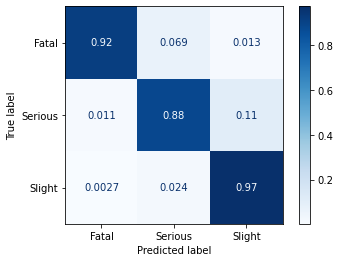

In [26]:
conf_mat = confusion_matrix(y_test, y_hatDecisionTree, normalize="true")

ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=decisionTreeModel.classes_
                      ).plot(cmap=plt.cm.Blues)

We notice the model accuracy for Fatal class is at 92 % and Serious class at 88 %. We wish to increase these values to help our objective.   

### Applying Random forest

In [27]:
randomForest = RandomForestClassifier(random_state=7)

# specifying the hyperparameters and values
parameterGrid = {
    'n_estimators': [10, 100, 200],
    'max_depth': [3, 5, 15],
    'min_samples_split': [5, 10]
}

# we'll use 10-fold cross-validation
gridSearchCVRandomForest = GridSearchCV(randomForest,
                            parameterGrid,
                            cv=10,
                            scoring='f1_macro',
                            return_train_score=True)

gridSearchCVRandomForest.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=7),
             param_grid={'max_depth': [3, 5, 15], 'min_samples_split': [5, 10],
                         'n_estimators': [10, 100, 200]},
             return_train_score=True, scoring='f1_macro')

In [28]:
displayScores(gridSearchCVRandomForest.cv_results_)

,params,mean_train_score,mean_test_score,"diff, %"
0,"{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 10}",0.549607,0.549422,0.033558
1,"{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}",0.614044,0.614111,-0.010895
2,"{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}",0.613700,0.613329,0.060356
3,"{'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 10}",0.549607,0.549422,0.033558
4,"{'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}",0.614044,0.614111,-0.010895
5,"{'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}",0.613700,0.613329,0.060356
6,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}",0.626236,0.620947,0.844663
7,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}",0.665299,0.663293,0.301416
8,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}",0.624332,0.619439,0.783718
9,"{'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10}",0.628441,0.623541,0.779732


In [29]:
gridSearchCVRandomForest.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=200,
                       random_state=7)

In [30]:
#Creating the random forest model from the obtained parameters
randomForestBestEstimator = RandomForestClassifier(max_depth= 15, min_samples_split= 10, random_state= 7)

randomForestModel = getModel('Downloads/RandomForest.sav')

if randomForestModel == None:
    print("Building model again")
    randomForestModel = randomForestBestEstimator.fit(X_train, y_train)

    
y_hatRandomForest = randomForestModel.predict(X_test)
y_hatRandomForest

saveModel('Downloads/RandomForest.sav', randomForestModel)

Building model again


In [31]:
#Find the f score for the Decision Tree model
precsion, recall, fscoreRandomForest, support = precision_recall_fscore_support(
    y_hatRandomForest, y_test, average="macro")

print(fscoreRandomForest)

#Check if this ir right way to do it.
improvementValueRandomForest = (
    (fscoreRandomForest - fscoreBaseModel) / fscoreBaseModel) * 100

print(
    "The improvement from the base model for the Random Forest model is",
    improvementValueRandomForest)

0.9038925481644706
The improvement from the base model for the Random Forest model is 204.17453325421064


Plotting the confusion matrix to understand TPR and TNR for Random forest

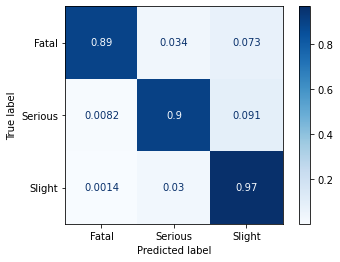

In [32]:
conf_mat = confusion_matrix(y_test, y_hatRandomForest, normalize="true")

ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=randomForestModel.classes_
                      ).plot(cmap=plt.cm.Blues)

We notice that although the model accuracy increases, it still was able to predict only 85 % of Fatal cases right but increased the accuracy for Serious class. 

Visualising the distribution of the target variable, casualty severity across the three categories.

In [33]:
casualtySeverity = dataFrameTrain.casualty_severity.value_counts().reset_index()

casualtySeverity

,index,casualty_severity
0,Slight,54206
1,Serious,12288
2,Fatal,908


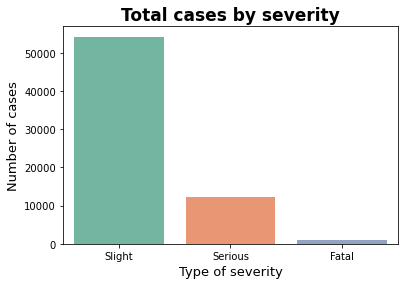

In [34]:
#Plotting a bar chart to visualise the distribution
ax = sns.barplot(x="index",
                 y="casualty_severity",
                 data=casualtySeverity,
                 ci=None,
                 palette="Set2")

configureGraph(ax, plt, "Type of severity", 13, "Number of cases", 13, False,
               "Total cases by severity", 17)

We observe that there is a high imbalance between the three categories. Slight has the highest number of records where as Fatal cases are very few. Such severe imbalance can lead to our model learning more from the dominant class and disregarding the other classes. 

We require that our model gives each class the same weightage while learning. Hence before preoceeding to balance the dataset, let us experiment with our best model so far, the RandomForest, by specifying the weights for the classes.

We use the default values of random forest hyperparameters and specify the class weight to be balanced so that the model places equal weight on each class.

In [35]:
randomForestEqualWeightBestEstimator = RandomForestClassifier(
                                                class_weight = "balanced")

randomForestEqualWeightModel = getModel('Downloads/RandomForestEqualWeight.sav')

if randomForestEqualWeightModel == None:
    print("Building model again")
    randomForestEqualWeightModel = randomForestEqualWeightBestEstimator.fit(X_train, y_train)

    
y_hatRandomForestEqualWeight = randomForestEqualWeightModel.predict(X_test)
y_hatRandomForestEqualWeight

saveModel('Downloads/RandomForestEqualWeight.sav', y_hatRandomForestEqualWeight)

Building model again


In [36]:
#Find the f score for the Random Forest model
precsion, recall, fscoreRandomForestEqualWeight, support = precision_recall_fscore_support(
    y_hatRandomForestEqualWeight, y_test, average="macro")

print(fscoreRandomForestEqualWeight)


improvementValueRandomForestEqualWeight = (
    (fscoreRandomForestEqualWeight - fscoreBaseModel) / fscoreBaseModel) * 100

print(
    "The improvement from the base model for the Random forest equal weight model is",
    improvementValueRandomForestEqualWeight)

improvementValueRandomForestEqualWeightOverNoWeights = (
    (fscoreRandomForestEqualWeight - fscoreRandomForest) /
    fscoreRandomForest) * 100

print(
    "The improvement from the random forest with equal weights over random forest with no weight prefrence for the  model is",
    fscoreRandomForestEqualWeight)

0.8911001346972007
The improvement from the base model for the Random forest equal weight model is 199.86967820976608
The improvement from the random forest with equal weights over random forest with no weight prefrence for the  model is 0.8911001346972007


We see a good accuracy by using the balanced class weight, which suggests that having an equal or almost equal distribution of the cases in the dataset might help achieve our target.

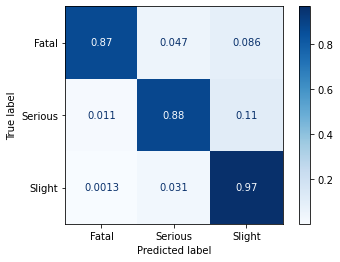

In [37]:
#Plotting a confusion matrix to understand the prediction accuracy for each class label

conf_mat = confusion_matrix(y_test, y_hatRandomForestEqualWeight, normalize="true")

ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=randomForestEqualWeightModel.classes_
                      ).plot(cmap=plt.cm.Blues)

In order to overcome the issue of imbalance in the class labels, we must ensure the difference in the class distributions is less.

We perform Oversampling to ensure the rare classes are equally represented in the data.

### Oversampling

Overampling is the process of generating duplicate records of the rare classes to combat the class imbalance.

We select oversampling here mainly for two reasons, first, it is computationally less intensive than undersampling. Second we aim to not lose the data by undersampling, having duplicate records of a class is comparatively a better trade off than losing valuable data.  

We use **Synthetic Minority Oversampling Technique (SMOTE)** to generate new instances of the rare cases in a balanced way.

By default SMOTE ensures each class has the same count. 

In [38]:
#The default mode of SMOTE creates an equal distribution among the three class labels
from collections import Counter
smote = SMOTE()

X_trainSampled, y_trainSampled = smote.fit_resample(X_train, y_train)

print(Counter(y_trainSampled))

Counter({'Slight': 54206, 'Serious': 54206, 'Fatal': 54206})


We see that after over sampling each class has an equal count.

We use random forest (our previous best model) to classify on this 

In [39]:
randomForestEqualWeightBestEstimator = RandomForestClassifier(max_depth = 15,
                                                 min_samples_split = 10,
                                                 random_state=7)

randomForestSmote = getModel('Downloads/RandomForestSmote.sav')

if randomForestSmote == None:
    print("Building model again")
    
    randomForestSmote = randomForestEqualWeightBestEstimator.fit(X_trainSampled, y_trainSampled)

    
y_hatRandomForestSmote = randomForestSmote.predict(X_test)
y_hatRandomForestSmote

saveModel('Downloads/RandomForestSmote.sav', y_hatRandomForestEqualWeight)

Building model again


In [40]:
precsion, recall, fscoreRandomForestSmote, support = precision_recall_fscore_support(
    y_hatRandomForestSmote, y_test, average="macro")

print(fscoreRandomForestSmote)


#Check if this ir right way to do it.
improvementValueRandomForestSmote = (
    (fscoreRandomForestSmote - fscoreBaseModel) / fscoreBaseModel) * 100

print(
    "The improvement from the base model for the Random forest equal weight model is",
    improvementValueRandomForestSmote)


improvementRandomForestSmoteOverRandomForest = (
    (fscoreRandomForestSmote - fscoreRandomForest) /
    fscoreRandomForest) * 100

0.8969593142114428
The improvement from the base model for the Random forest equal weight model is 201.84138734445946


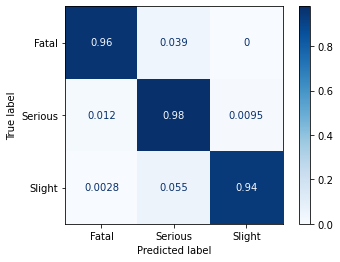

In [41]:
#Plotting a confusion matrix
conf_mat = confusion_matrix(y_test, y_hatRandomForestSmote, normalize="true")

ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=randomForestSmote.classes_
                      ).plot(cmap=plt.cm.Blues)

We were able to increase the accuracy for Fatal and Severe to 97 and 98 percent respectively, obtaining the desired output. 

### Applying Neural Network

In [42]:
import tensorflow as tf

In [43]:
#We use tensor flow to create a neural network
ann = tf.keras.models.Sequential()
#We create the input and output layers
ann.add(tf.keras.layers.Dense(units=4,activation="relu"))
ann.add(tf.keras.layers.Dense(units=6,activation="relu"))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

y_trainNumeric = y_train.replace(["Slight", "Serious", "Fatal"], [1,2,3])

#We only use 10 epochs as they are computationally exhaustive.
ann.fit(X_train,y_trainNumeric,batch_size=16,epochs = 10)

y_hatAnn = ann.predict(X_test)

y_hatAnn

Epoch 1/10
4213/4213 [==============================] - 5s 1ms/step - loss: -8773.6611 - accuracy: 0.8042
Epoch 2/10
4213/4213 [==============================] - 4s 1ms/step - loss: -94652.7891 - accuracy: 0.8042
Epoch 3/10
4213/4213 [==============================] - 4s 1ms/step - loss: -322326.7500 - accuracy: 0.8042
Epoch 4/10
4213/4213 [==============================] - 5s 1ms/step - loss: -740173.7500 - accuracy: 0.8042
Epoch 5/10
4213/4213 [==============================] - 4s 1ms/step - loss: -1402597.0000 - accuracy: 0.8042
Epoch 6/10
4213/4213 [==============================] - 4s 1ms/step - loss: -2343010.2500 - accuracy: 0.8042
Epoch 7/10
4213/4213 [==============================] - 4s 1ms/step - loss: -3625739.5000 - accuracy: 0.8042
Epoch 8/10
4213/4213 [==============================] - 4s 1ms/step - loss: -5292737.5000 - accuracy: 0.8042
Epoch 9/10
4213/4213 [==============================] - 4s 1ms/step - loss: -7374895.5000 - accuracy: 0.8042
Epoch 10/10
4213/4213 [===

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [44]:
y_testNumeric  = y_test.replace(["Slight", "Serious", "Fatal"], [1,2,3])

precsion, recall, fscoreAnn, support = precision_recall_fscore_support(
y_hatAnn, y_testNumeric, average="macro")

print("F score for neural network:",fscoreAnn)

F score for neural network: 0.29688723046074994


We do not observe a high accuracy for neural network, since this model requires a large amount of data for training and is computationally very demanding, hence we do not create many epochs here. 

# Conclusion

The project began by combining datasets to obtain the required data to rightly predict the casualty severity for a accident, this would greatly benefit the emergency department at hospitals as they would be able to decide the seriousness of the case and make the right arrangements. This can save precious time and help save the patients life. Through EDA, we obtained several meaningful insights such as the day of the week with most cases and the severity type. We were also able to analyse this data on granular time period level of a day. 

We were able to increase our model accuracy of predicting **Fatal** and **Severe** cases inspite of having less data on such observations. Random forest model trained on the oversampled data seemed to have the best results

# Possible future improvements

After employing ensemble algorithms such as random forest, we were able to increase the accuracy and the true positive rate for our model. In the initial process we did eliminate or imputed records due to them being outliers and having undefined data. This does affect the quality of the data and thus the modelling process. 

Obtaining data with better quality, which represents the underlying phenomenon better would aid in better results. We applied advanced learning methods such as Neural networks, which have a higher predective power in general but require large amounts of data to be effectively trained. Such methods also demand high computational power, thus not being ideal options to run on average computer. The hosiptal could invest in machines capable of higher processing power and there by having a high accuracy overall in predicting the severity. 